In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

In [2]:
# Creation des classes pour avoir les nombres de fourmies, les noeuds et la capacité des noeuds

class Anthill:
    def __init__(self, file_path, file_number=5):
        # Charger les données JSON à partir du fichier
        with open(file_path, 'r') as file:
            self.json_data = json.load(file)[f'antshill_{file_number}']

        # Nombre de fourmis dans cette fourmilière
        self.num_ants = self.json_data["f"]
        
        # Connexions entre les chambres
        self.nodes = self.json_data["Nodes"]
        
        # Initialiser les capacités des chambres avec une capacité par défaut de 1
        self.capacities = {node: 1 for node in self.nodes.keys()}
        
        # Mettre à jour les capacités spécifiques si elles existent dans les données JSON
        if "shape" in self.json_data and self.json_data["shape"]:
            for room_capacity in self.json_data["shape"]:
                self.capacities.update(room_capacity)

    def get_ants(self):
        """Retourne le nombre de fourmis dans cette fourmilière"""
        return self.num_ants

    def get_connections(self):
        """Retourne les connexions entre les chambres"""
        return self.nodes

    def get_capacities(self):
        """Retourne les capacités des chambres"""
        return self.capacities

    def visualize(self, seed=12):
        F = nx.Graph()
    
        # Ajouter des nœuds
        color_map = []
        for node in self.nodes.keys():
            F.add_node(node)
    
            if node == "Sv":
                color_map.append('#930ac9')
            elif node == "Sd":
                color_map.append('#7edb32')
            else:
                color_map.append('#1ea4d9')
    
        # Ajouter des arêtes
        for node in self.nodes.keys():
            for edge in self.nodes[node]:
                F.add_edge(node, edge)
    
        # Utilisation d'une disposition avec un seed pour la stabilité
        pos = nx.spring_layout(F, seed=seed)
        
        # Dessiner le graphe avec les positions calculées
        nx.draw(F, pos, with_labels=True, node_color=color_map, node_size=500)
        plt.show()

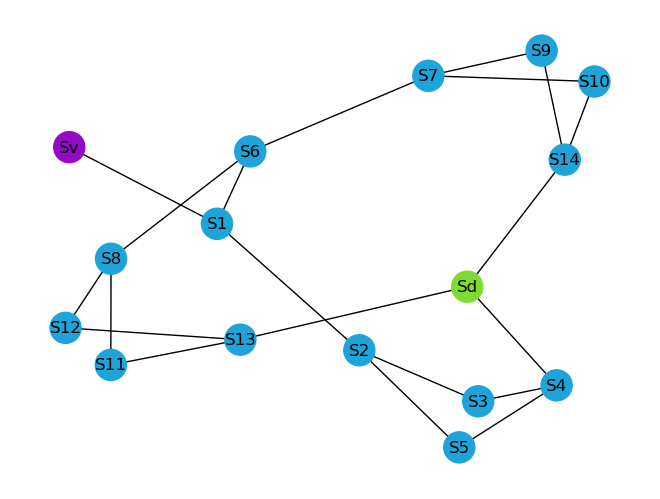

Nombre de fourmis: 50
Connexions des chambres: {'S1': ['S2', 'Sv', 'S6'], 'S2': ['S1', 'S3', 'S5'], 'S3': ['S2', 'S4'], 'S4': ['S3', 'Sd', 'S5'], 'S5': ['S2', 'S4'], 'S6': ['S1', 'S7', 'S8'], 'S7': ['S6', 'S9', 'S10'], 'S8': ['S6', 'S12', 'S11'], 'S9': ['S7', 'S14'], 'S10': ['S7', 'S14'], 'S11': ['S8', 'S13'], 'S12': ['S8', 'S13'], 'S13': ['S11', 'S12', 'Sd'], 'S14': ['S9', 'S10', 'Sd'], 'Sd': ['S4', 'S13', 'S14'], 'Sv': ['S1']}
Capacités des chambres: {'S1': 8, 'S2': 4, 'S3': 2, 'S4': 4, 'S5': 2, 'S6': 4, 'S7': 2, 'S8': 5, 'S9': 1, 'S10': 1, 'S11': 1, 'S12': 1, 'S13': 4, 'S14': 2, 'Sd': 1, 'Sv': 1}


In [3]:
#Je prends les données nécessaire pour ce files
file_number=5

if __name__ == "__main__":
    # Chemin vers le fichier JSON
    file_path = 'antshill.json'
    
    # Créer une instance d'Anthill pour la fourmilière 1
    anthill = Anthill(file_path, file_number)

    # Accéder au nombre de fourmis, aux connexions et aux capacités
    nb = anthill.get_ants()
    N = anthill.get_connections()
    Cap = anthill.get_capacities()
    anthill.visualize()
    print("Nombre de fourmis:", nb)
    print("Connexions des chambres:", N)
    print("Capacités des chambres:", Cap)

In [4]:
# Extraire les nœuds et les capacités
nodes = N
capacities = Cap

# Ajouter une capacité infinie pour la chambre de destination (Sd)
capacities["Sd"] = float('inf')

# Création du graphe avec NetworkX
G = nx.Graph()
for node, neighbors in nodes.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Fonction pour calculer le plus court chemin
def shortest_path(G, start, end):
    # Calcul du plus court chemin
    path = nx.shortest_path(G, source=start, target=end)
    return path

# Fonction pour afficher le chemin le plus court
def display_shortest_path(path):
    print("Le chemin le plus court est :")
    print(" -> ".join(path))

In [5]:
# Initialiser les positions des fourmis
def initialize_positions(num_ants, start):
    return {f"f{i+1}": start for i in range(num_ants)}

In [6]:
# Fonction pour déplacer les fourmis tout en respectant la capacité des chambres
def move_ants_with_capacity(positions, path, capacities):
    new_positions = positions.copy()
    room_occupancy = {node: list(positions.values()).count(node) for node in path}  # Compter les fourmis par chambre

    for ant, pos in positions.items():
        if pos != path[-1]:  # Si la fourmi n'est pas encore arrivée à destination
            next_pos = path[path.index(pos) + 1]  # Prochaine position dans le chemin
            # Vérifier si la prochaine chambre peut accueillir plus de fourmis
            if room_occupancy[next_pos] < capacities[next_pos]:  # Respecter la capacité
                new_positions[ant] = next_pos  # Déplacer la fourmi
                room_occupancy[pos] -= 1  # Mettre à jour l'occupation de la chambre actuelle
                room_occupancy[next_pos] += 1  # Mettre à jour l'occupation de la prochaine chambre
            else:
                continue  # Si la chambre est pleine, la fourmi reste en place
    return new_positions

In [7]:
def simulate_ants_movement_with_capacity(G, capacities, start, end, num_ants):
    # 1. Calculer et afficher le chemin le plus court
    path = shortest_path(G, start, end)
    display_shortest_path(path)

    # 2. Simuler le déplacement des fourmis étape par étape en respectant les capacités
    positions = initialize_positions(num_ants, start)  # Initialiser les positions des fourmis
    step = 1

    while any(pos != end for pos in positions.values()):  # Tant que toutes les fourmis ne sont pas arrivées
        print(f"\n+++ Étape {step} +++")
        for ant, pos in positions.items():
            print(f"{ant} est dans {pos}")
        
        # Déplacer les fourmis tout en respectant la capacité
        positions = move_ants_with_capacity(positions, path, capacities)
        step += 1
    
    # Dernière étape où toutes les fourmis sont arrivées
    print(f"\n+++ Étape {step} +++")
    for ant, pos in positions.items():
        print(f"{ant} est dans {pos}")

In [64]:
simulate_ants_movement_with_capacity(G, capacities, "Sv", "Sd", nb)

Le chemin le plus court est :
Sv -> S1 -> S2 -> S3 -> S4 -> Sd

+++ Étape 1 +++
f1 est dans Sv
f2 est dans Sv
f3 est dans Sv
f4 est dans Sv
f5 est dans Sv
f6 est dans Sv
f7 est dans Sv
f8 est dans Sv
f9 est dans Sv
f10 est dans Sv
f11 est dans Sv
f12 est dans Sv
f13 est dans Sv
f14 est dans Sv
f15 est dans Sv
f16 est dans Sv
f17 est dans Sv
f18 est dans Sv
f19 est dans Sv
f20 est dans Sv
f21 est dans Sv
f22 est dans Sv
f23 est dans Sv
f24 est dans Sv
f25 est dans Sv
f26 est dans Sv
f27 est dans Sv
f28 est dans Sv
f29 est dans Sv
f30 est dans Sv
f31 est dans Sv
f32 est dans Sv
f33 est dans Sv
f34 est dans Sv
f35 est dans Sv
f36 est dans Sv
f37 est dans Sv
f38 est dans Sv
f39 est dans Sv
f40 est dans Sv
f41 est dans Sv
f42 est dans Sv
f43 est dans Sv
f44 est dans Sv
f45 est dans Sv
f46 est dans Sv
f47 est dans Sv
f48 est dans Sv
f49 est dans Sv
f50 est dans Sv

+++ Étape 2 +++
f1 est dans S1
f2 est dans S1
f3 est dans S1
f4 est dans S1
f5 est dans S1
f6 est dans S1
f7 est dans S1
f8 est 

In [65]:
# Modification du code d'en haut pour enregistrer les étapes dans un fichier txt
def simulate_ants_movement_with_capacity(G, capacities, start, end, num_ants, output_file):
    # Ouvrir le fichier en mode écriture
    with open(output_file, 'w') as file:
        # 1. Calculer et afficher le chemin le plus court
        path = shortest_path(G, start, end)
        file.write("Le chemin le plus court est :\n")
        file.write(" -> ".join(path) + "\n")

        # 2. Simuler le déplacement des fourmis étape par étape en respectant les capacités
        positions = initialize_positions(num_ants, start)  # Initialiser les positions des fourmis
        step = 1

        while any(pos != end for pos in positions.values()):  # Tant que toutes les fourmis ne sont pas arrivées
            file.write(f"\n+++ Étape {step} +++\n")
            for ant, pos in positions.items():
                file.write(f"{ant} est dans {pos}\n")
            
            # Déplacer les fourmis tout en respectant la capacité
            positions = move_ants_with_capacity(positions, path, capacities)
            step += 1
        
        # Dernière étape où toutes les fourmis sont arrivées
        file.write(f"\n+++ Étape {step} +++\n")
        for ant, pos in positions.items():
            file.write(f"{ant} est dans {pos}\n")

In [66]:
# Exemple d'utilisation : enregistrer la simulation dans un fichier
simulate_ants_movement_with_capacity(G, capacities, "Sv", "Sd", nb, "simulation_output.txt")

In [67]:
# Fonction pour calculer le plus court chemin et afficher le graphe avec surbrillance
def draw_graph_with_shortest_path(G, start, end):
    # 1. Calculer le plus court chemin
    path = nx.shortest_path(G, source=start, target=end)
    
    # 2. Dessiner le graphe en surlignant le chemin le plus court
    pos = nx.spring_layout(G, seed=12)  # Garde la position des nœuds constante avec seed

    # Dessiner tous les nœuds
    nx.draw_networkx_nodes(G, pos, node_color="lightgray", node_size=500)

    # Dessiner toutes les arêtes en noir
    nx.draw_networkx_edges(G, pos, edge_color="black")

    # Dessiner les labels des nœuds
    nx.draw_networkx_labels(G, pos)

    # Colorier le chemin le plus court en bleu
    path_edges = list(zip(path, path[1:]))  # Extraire les arêtes du chemin
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=3)  # Surligner le chemin

    # Afficher le graphe
    plt.title(f"Shortest Path from {start} to {end} from file #{file_number}")
    plt.show()

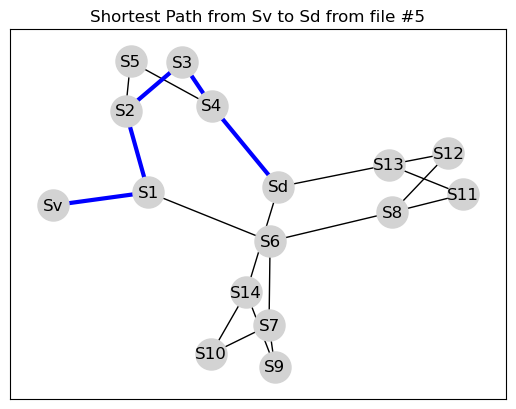

In [68]:
# Exemple d'utilisation pour dessiner le graphe avec le chemin le plus court
draw_graph_with_shortest_path(G, "Sv", "Sd")

# Test pour voir siµ ça marche avec plusieurs chemin